#  Fitting Linear & Logistic Regression Models with Gradient Descent

Linear and Logistic Regression are both foundational supervised regression & classification algorithms. They're both linear supervised models that are trained by minimizing a cost function, given a training dataset and a set of parameters to optimize. This optimization is usually done using a gradient-based method like Gradient Descent or Stochastic Gradient Descent. 

This notebook will define Gradient Descent and detail how it's used to fit Linear & Logistic Regression models.

In [1]:
from copy import copy
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import LogNorm
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Gradient Descent

Gradient descent is a simple optimization algorithm that's ubiquitous in model training algorithms. It's perfect for finding a global miminum in a convex optimization function. The cost functions for both Linear and Logistic Regression both happen to be convex functions, so Gradient Descent is a perfect algorithm for finding an optimal set of parameters.

To illustrate Gradient Descent, let's examine Linear Regression in detail. A linear model is defined
$$
y_{i} = \theta_{0} + \theta_{1}x_{i}^{(1)} + \theta_{2}x_{i}^{(2)} + \ldots + \theta_{d}x_{i}^{(d)} + \epsilon_{i}
$$

for each observation i=1 to N. We can also write this in matrix form:

$$
y = X\theta + \epsilon
$$

Where Y is an Nx1 vector, X is an Nxd matrix, $\theta$ is a dx1 vector, and $\epsilon$ is an Nx1 vector of error terms. To use Gradient Descent to optimize this function, we must define a cost function. For linear regression, it's the Mean Squared Error (MSE):

$$
J(\theta) = \frac{1}{N} \sum_{i=1}^{N}(\theta^{T}\textbf{x}_{i} - y_{i})^2
$$

in matrix notation:

$$
J(\theta) = \frac{1}{N} (\textbf{X}\theta - \textbf{y})^T(\textbf{X}\theta - \textbf{y})
$$


Let's derive the gradient of $J(\theta)$ w.r.t to the vector of parameters $\theta$. First, let's expand out the quadratic terms:

$$
J(\theta) = \frac{1}{N} (\textbf{X}\theta - \textbf{y})^T(\textbf{X}\theta - \textbf{y})
$$

$$
= \frac{1}{N}( \theta^{T}\textbf{X}^{T}\textbf{X}\theta + 2\textbf{y}^{T}\textbf{X}\theta + \textbf{y}^{T}\textbf{y})
$$

Now find the gradient:

$$
\nabla_{\theta} J(\theta) = \frac{1}{N}( 2\textbf{X}^{T}\textbf{X}\theta - 2\textbf{y}^{T}\textbf{X} )
$$

$$
= \frac{2}{N}( \textbf{X}^{T}\textbf{X}\theta - \textbf{X}^{T}\textbf{y} )
$$


$$
= \frac{2}{N} ( \textbf{X}^{T} ( \textbf{X}\theta - \textbf{y} )  )
$$

Great. Given data matrix *X*, parameter vector *theta*, and label vector *y*, we can define this in numpy like so:

~~~
gradient = 2/m * X.T.dot(X.dot(theta) - y)
~~~

Gradient Descent entails iteratively updating our estimated $\theta$ vector until we've reached the global minimum value of the cost function, or we've reached some predefined limited number of iterations:

$$
let \space \eta = learning \space rate \space (some \space \space number \space less \space than \space 1, \space like \space 0.01) \\
\theta_{i+1} = \theta_{i} - \eta\nabla_{\theta}
$$

Let's see gradient descent in action! First, we'll create some fake data:

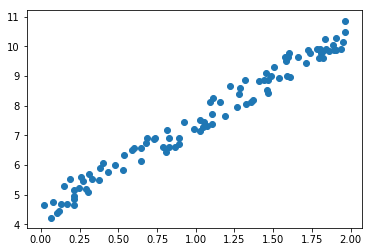

In [27]:
# Create fake data for a univariate regression, y = 4 + 3x_i + e_i
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.rand(100,1)
plt.scatter(X, y)

To illustrate the algorithm, we'll scatter plot the data, then iteratively 
1. Calculate the gradient of the loss function w.r.t the parameters, and update theta
2. Plot the line of best fit for that iteration
3. Calculate and save the MSE

We'll also plot the MSE as it changes with each iteration.

Text(0,0.5,'MSE')

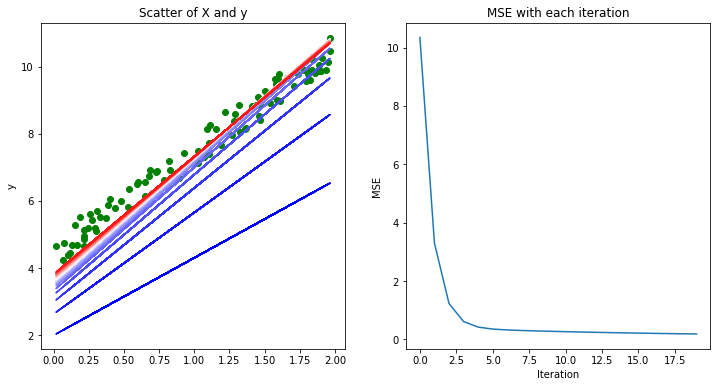

In [28]:
# Set up: Add a bias term to X, initialize the parameters to random values, and set the learning rate & number of iterations
X_b = np.hstack([np.ones((100,1)), X])  # add a column of ones to X so we also calculate an intercept
theta = np.random.rand(2,1)
eta = 0.1
n_iter = 20

f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
f.set_size_inches(12, 6)

# First plot: scatter plot of X & y, with fitted lines that turn more redd with each iteration
ax1.scatter(X, y, c='g')
ax1.set_title('Scatter of X and y')
ax1.set_ylabel('y')
ax2.set_xlabel('X')

# Set up the colour map for the fitted lines
cm = plt.get_cmap('bwr')
ax1.set_color_cycle([cm(i/n_iter) for i in range(n_iter)])

mses = []

for i in range(n_iter):
    
    # Calculate the gradient and update the parameters
    gradient = (2/X.shape[0]) * X_b.T.dot(X_b.dot(theta) - y)
    theta -= eta * gradient
    
    # Calculate the predicted values for all observations, then calculate the MSE
    y_pred = X_b.dot(theta)
    mse = np.sum(((y_pred - y) ** 2)) / X.shape[0]
    
    # Plot the fitted line for this iteration in the first plot
    ax1.plot(X, y_pred)
    
    # Save the calculated mse
    mses.append(copy(mse))  # append a copy of the mse to the mses list since Python lists are referential
    
# Second plot: The MSE with each iteration
ax2.plot(mses)
ax2.set_title('MSE with each iteration')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('MSE')

# f.tight_layout()

We can see that with each iteration, the regression line fits the data better, and the MSE falls. This illustrates that we're approaching the cost function's global minimum with each iteration of Gradient Descent.

For logistic regression, the loss function looks like this:

$$z _{i} = \theta^{T}x_{i}$$

$$\sigma(z_{i}) = \frac{1}{1 + e^{-z}}$$


$$J(\theta) = \frac{1}{N} \sum_{i=1}^{N} y_{i}log(\sigma(z_{i})) + (1 - y_{i})log(1 - \sigma(z_{i}))$$

We'll use the Chain Rule to find the derivative w.r.t $\theta_{j}$:

$$\frac{\partial J(\theta)}{\partial \theta_{j}} = \frac{\partial J}{\partial \sigma}  \frac{\partial \sigma}{\partial z}  \frac{\partial z}{\partial \theta_{j}}$$

$\frac{\partial z}{\partial \theta_{j}}$ is just $x_{j}$, while $\frac{\partial \sigma}{\partial z}$ is $\sigma(1 - \sigma)$ (a nice property of the sigmoid function 👍). Thus, $\frac{\partial J(\theta)}{\partial \theta_{j}}$ can be derived:

$$J(\theta) = \frac{1}{N} \sum_{i=1}^{N} y_{i}log(\sigma(\hat{z}_{i})) + (1 - y_{i})log(1 - \sigma(\hat{z}_{i}))$$

$$\frac{\partial J(\theta)}{\partial \theta_{j}} =  \frac{1}{N} \sum (\frac{y_{i}}{\sigma} - \frac{1 - y_{i}}{1 - \sigma})\sigma(1 - \sigma)x_{j}$$

$$ = \frac{1}{N} \sum ( \frac{y_{i}(1 - \sigma) - \sigma(1 - y_{i})}{\sigma(1 - \sigma)} ) \sigma(1 - \sigma) x_{j}$$

$$ = \frac{1}{N} \sum ( y_{i} - y_{i}\sigma - \sigma + y_{i}\sigma ) x_{j}$$

$$ = \frac{1}{N} \sum ( y_{i} - \sigma )x_{j}$$

In a vectorized form:

$$\frac{\partial J(\theta)}{\partial \theta_{j}} = \frac{1}{N}\textbf{x}_{j}^{T}( \textbf{y} - \sigma )$$

And the gradient w.r.t all $\theta$s:

$$\nabla_{\theta} J(\theta) = \frac{1}{N} X^{T}( y - \sigma )$$

We can define this in code like so:
~~~

# Given data matrix X, parameter vector theta, and label vector y (expressed as numpy arrays)

def sigmoid(X, theta): 
    return 1 / (1 + np.exp(X.dot(theta)))

logit_gradient = (1/X.shape[0]) * X.T.dot(y - sigmoid(X, theta))
~~~

Let's illustrate gradient descent for Logistic Regression like we did before with Linear Regression:

In [2]:
# from sklearn.datasets import make_classification

X, y = make_classification(n_features=2, n_informative=2, n_redundant=0, 
                           n_clusters_per_class=1, class_sep=1.1)

# x1 = np.random.multivariate_normal([0, 0], [[1, .75],[.75, 1]], 50)
# x2 = np.random.multivariate_normal([1, 4], [[1, .75],[.75, 1]], 50)

# X = np.hstack((x1, x2)).astype(np.float32)
# y = np.hstack((np.zeros(50), np.ones(50)))

X_b = np.hstack([np.ones((100,1)), X])  # add a column of ones to X so we also calculate an intercept
theta = np.random.rand(X.shape[1] + 1)
eta = 0.1
n_iter = 1000

f, ax = plt.subplots(nrows=1, ncols=1)

# Scatter plot the data for the two classes in red and blue
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
ax.scatter(X[:,0], X[:,1], c=y, cmap=cm_bright)

cm_logit = plt.get_cmap('Purples')
ax.set_color_cycle([cm_logit(i/n_iter) for i in range(n_iter)])

def sigmoid(X, theta): 
    return np.squeeze(1 / (1 + np.exp(-1 * X.dot(theta))))

log_losses = []

for i in range(n_iter):
    logit_gradient = (1/X.shape[0]) * X.T.dot(y - sigmoid(X, theta))
    theta += eta * logit_gradient
    
    log_loss = -1 * (1/X_b.shape[0]) * (np.log(sigmoid(X_b, theta)).dot(y) + np.log(1 - sigmoid(X_b, theta)).dot(1 - y))
    log_losses.append(copy(log_loss))
    
    # Plot the decision boundary
    w = theta[1:]
    a = -w[0] / w[1]
    xx = np.linspace(-2,2)
    yy = a * xx - (theta[0] / w[1])
    yy = yy / np.max(np.abs(yy))
    plt.plot(xx, yy)

NameError: name 'make_classification' is not defined

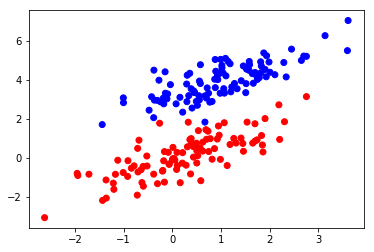

In [52]:
np.random.seed(12)
num_observations = 100

x1 = np.random.multivariate_normal([0, 0], [[1, .75],[.75, 1]], num_observations)
x2 = np.random.multivariate_normal([1, 4], [[1, .75],[.75, 1]], num_observations)

X = np.vstack((x1, x2)).astype(np.float32)
y = np.hstack((np.zeros(num_observations),
                              np.ones(num_observations)))

X_b = np.hstack([np.ones((200,1)), X])  # add a column of ones to X so we also calculate an intercept
theta = np.random.rand(X.shape[1] + 1)
eta = 0.001
n_iter = 300000

f, ax = plt.subplots(nrows=1, ncols=1)
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)

cm_logit = plt.get_cmap('Purples')
ax.set_color_cycle([cm_logit(i/n_iter) for i in range(n_iter)])

def sigmoid(X, theta): 
    return np.squeeze(1 / (1 + np.exp(-1 * X.dot(theta))))



log_losses = []

for i in range(n_iter):
    logit_gradient = (1/X.shape[0]) * X_b.T.dot(y - sigmoid(X_b, theta))
    theta += eta * logit_gradient
    
    log_loss = (1/X_b.shape[0]) * (np.log(sigmoid(X_b, theta)).dot(y) + np.log(1 - sigmoid(X_b, theta)).dot(1 - y))
    log_losses.append(copy(log_loss))
    
    # Plot the decision boundary
#     w = theta[1:]
#     a = -w[0] / w[1]
#     xx = np.linspace(-2,2)
#     yy = a * xx - (theta[0] / w[1])
#     yy = yy / np.max(np.abs(yy))
#     ax.plot(xx, yy)

In [53]:
theta

array([-5.54105   , -2.14392869,  3.35702276])

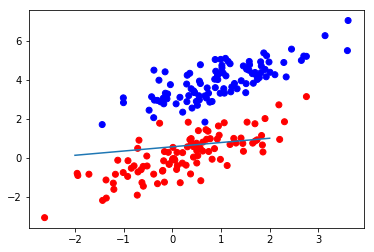

In [54]:
f, ax = plt.subplots(nrows=1, ncols=1)
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)


w = theta[1:]
a = -w[0] / w[1]
xx = np.linspace(-2,2)
yy = a * xx - (theta[0] / w[1])
yy = yy / np.max(np.abs(yy))
ax.plot(xx, yy)

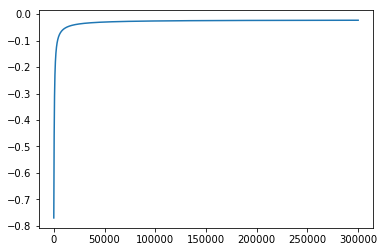

In [43]:
plt.plot(log_losses)

In [55]:
clf = LogisticRegression(fit_intercept=True, C = 1e15)
clf.fit(X, y)

LogisticRegression(C=1000000000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [56]:
clf.coef_

array([[-3.49640694,  6.29086489]])

In [57]:
clf.intercept_

array([-11.5153695])

In [61]:
theta2 = np.append(clf.intercept_,clf.coef_)
theta2

array([-11.5153695 ,  -3.49640694,   6.29086489])